In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.imports import *
from fastai.core import *
from fastai.io import *
from fastai.dataloader import *
from fastai.conv_learner import *
from fastai.learner import *
import os
from audio_dataset import *
from audio_transforms import *

import IPython.display as ipd

In [2]:
import librosa
from librosa import display

## Load Data

In [3]:
PATH = Path('data/freesound')
TRN_PATH = PATH/'audio_train'
TEST_PATH = PATH/'audio_test'

In [4]:
trn = pd.read_csv(PATH/'train.csv')
test = pd.read_csv(PATH/'sample_submission.csv')

In [ ]:
verified = list(trn['manually_verified'])

In [5]:
trn = trn[['fname','label']].copy()
trn_sample = trn[:200]
trn.head()

,fname,label
0,00044347.wav,Hi-hat
1,001ca53d.wav,Saxophone
2,002d256b.wav,Trumpet
3,0033e230.wav,Glockenspiel
4,00353774.wav,Cello


In [6]:
trn.to_csv('trn.csv', index=False)
trn_sample.to_csv('trn_sample.csv', index=False)

In [7]:
trn.shape[0], len(trn.label.unique())

(9473, 41)

In [11]:
fnames = list(trn['fname']) 
test_fnames = list(test['fname']) 
len(fnames), len(test_fnames)

(9473, 9400)

In [13]:
trn_wavs = (PATH/'audio_train').glob('*.wav')
test_wavs = (PATH/'audio_test').glob('*.wav')

In [147]:
stats = (np.array([0.19614]), np.array([0.32234]))

### Listen to Sounds

In [48]:
[preds[i] for i in idx[:10]]

['Fireworks Finger_snapping Microwave_oven',
 'Oboe Flute Trumpet',
 'Bass_drum Knock Fireworks',
 'Double_bass Bass_drum Knock',
 'Oboe Electric_piano Telephone',
 'Bass_drum Knock Double_bass',
 'Squeak Violin_or_fiddle Harmonica',
 'Gong Acoustic_guitar Chime',
 'Flute Telephone Clarinet',
 'Saxophone Flute Clarinet']

In [136]:
test_preds = list(test.label[:10])

In [174]:
l=3*44100 #seconds * sample_rate
n = 5

#play sample with stats
#length = 3*44100
#sample = os.path.join(TRN_PATH, fnames[n])
sample = os.path.join(TEST_PATH, test_fnames[n])
print(test_fnames[n])
raw = open_audio(sample)
raw_len = len(raw)
raw_s = adj_length(raw)
print('raw length: ', raw_len, 'sample length:', len(raw_s))
#print('label:', trn['label'].iloc[n], 'verified:', verified[n])
print('prediction:', test_preds[n])
ipd.Audio(raw_s, rate=44100)

0038a046.wav
raw length:  132300 sample length: 441000
prediction: Bass_drum Knock Writing


## Model

In [30]:
def preprocess_ys(labels, one_hot=False):
    if isinstance(labels[0], str):
        tok2int = {v:k for k,v in enumerate(np.unique(labels))}
        labels = np.array([tok2int[tok] for tok in labels])
    num_classes = len(np.unique(labels))
    if one_hot:
        return [one_hot(labels[i], num_classes).reshape(1, num_classes) for i in range(len(labels))]
    else:
        return labels

In [31]:
labels = list(trn['label'])
labels = preprocess_ys(labels)
labels[:5], labels.shape

(array([23, 30, 38, 19,  6]), (9473,))

In [32]:
labels_samp = list(trn['label'])[:200]
labels_samp = preprocess_ys(labels_samp)
#labels_samp = one_hot(labels_samp, len(classes))
labels_samp[:2], labels_samp.shape

(array([23, 30]), (200,))

### Audio_transforms

In [99]:
class Transform():
    """ A class that represents a transform.

    All other transforms should subclass it. All subclasses should override
    do_transform.

    Arguments
    ---------
        tfm_y : TfmType
            type of transform
    """
    def __init__(self, tfm_y=TfmType.NO):
        self.tfm_y=tfm_y
        self.store = threading.local()

    def set_state(self): pass
    def __call__(self, x, y):
        self.set_state()
        x,y = ((self.transform(x),y) if self.tfm_y==TfmType.NO
                else self.transform(x,y) if self.tfm_y in (TfmType.PIXEL, TfmType.CLASS)
                else self.transform_coord(x,y))
        return x, y

    def transform_coord(self, x, y): return self.transform(x),y

    def transform(self, x, y=None):
        x = self.do_transform(x,False)
        return (x, self.do_transform(y,True)) if y is not None else x

    @abstractmethod
    def do_transform(self, x, is_y): raise NotImplementedError


class Denormalize():
    """ De-normalizes an image, returning it to original format.
    """
    def __init__(self, m, s):
        self.m=np.array(m, dtype=np.float32)
        self.s=np.array(s, dtype=np.float32)
    def __call__(self, x): return x*self.s+self.m


class Normalize():
    """ Normalizes an image to zero mean and unit standard deviation, given the mean m and std s of the original image """
    def __init__(self, m, s): #tfm_y=TfmType.NO
        self.m=np.array(m, dtype=np.float32)
        self.s=np.array(s, dtype=np.float32)
        #self.tfm_y=tfm_y

    def __call__(self, x, y=None):
        x = (x-self.m)/self.s
        #if self.tfm_y==TfmType.PIXEL and y is not None: y = (y-self.m)/self.s
        return x,y

       
def compose(im, y, fns):
    """ apply a collection of transformation functions fns to images
    """
    for fn in fns:
        #pdb.set_trace()
        im, y =fn(im, y)
    return im if y is None else (im, y)


class Transforms():
    def __init__(self, sz, tfms, normalizer, denorm, crop_type=CropType.CENTER,
                 tfm_y=TfmType.NO, sz_y=None):
        if sz_y is None: sz_y = sz
        self.sz,self.denorm,self.norm,self.sz_y = sz,denorm,normalizer,sz_y
        crop_tfm = crop_fn_lu[crop_type](sz, tfm_y, sz_y)
        self.tfms = tfms
        self.tfms.append(crop_tfm)
        if normalizer is not None: self.tfms.append(normalizer)
        self.tfms.append(ChannelOrder(tfm_y))

    def __call__(self, im, y=None): return compose(im, y, self.tfms)
    def __repr__(self): return str(self.tfms)


def image_gen(normalizer, denorm, sz, tfms=None, max_zoom=None, pad=0, crop_type=None,
              tfm_y=None, sz_y=None, pad_mode=cv2.BORDER_REFLECT, scale=None):
    """
    Generate a standard set of transformations

    Arguments
    ---------
     normalizer :
         image normalizing function
     denorm :
         image denormalizing function
     sz :
         size, sz_y = sz if not specified.
     tfms :
         iterable collection of transformation functions
     max_zoom : float,
         maximum zoom
     pad : int,
         padding on top, left, right and bottom
     crop_type :
         crop type
     tfm_y :
         y axis specific transformations
     sz_y :
         y size, height
     pad_mode :
         cv2 padding style: repeat, reflect, etc.

    Returns
    -------
     type : ``Transforms``
         transformer for specified image operations.

    See Also
    --------
     Transforms: the transformer object returned by this function
    """
    if tfm_y is None: tfm_y=TfmType.NO
    if tfms is None: tfms=[]
    elif not isinstance(tfms, collections.Iterable): tfms=[tfms]
    if sz_y is None: sz_y = sz
    if scale is None:
        scale = [RandomScale(sz, max_zoom, tfm_y=tfm_y, sz_y=sz_y) if max_zoom is not None
                 else Scale(sz, tfm_y, sz_y=sz_y)]
    elif not is_listy(scale): scale = [scale]
    if pad: scale.append(AddPadding(pad, mode=pad_mode))
    if crop_type!=CropType.GOOGLENET: tfms=scale+tfms
    return Transforms(sz, tfms, normalizer, denorm, crop_type,
                      tfm_y=tfm_y, sz_y=sz_y)

def noop(x):
    """dummy function for do-nothing.
    equivalent to: lambda x: x"""
    return x

class AudTransforms():
    def __init__(self, tfms, normalizer, denorm):
        #if sz_y is None: sz_y = sz
        #self.sz,self.denorm,self.norm,self.sz_y = sz,denorm,normalizer,sz_y
        self.denorm,self.norm = denorm,normalizer
        #crop_tfm = crop_fn_lu[crop_type](sz, tfm_y, sz_y)
        self.tfms = tfms
        #self.tfms.append(crop_tfm)
        if normalizer is not None: self.tfms.append(normalizer)
        #self.tfms.append(ChannelOrder(tfm_y))

    def __call__(self, im, y=None): return compose(im, y, self.tfms) 
    def __repr__(self): return str(self.tfms)

def audio_gen(normalizer, denorm, tfms=None):
    if tfms is None: tfms = []
    elif not isinstance(tfms, collections.Iterable): tfms=[tfms]
    return AudTransforms(tfms, normalizer, denorm)

def aud_tfms_from_stats(stats, aug_tfms=None):
#def tfms_from_stats(stats, sz, aug_tfms=None, max_zoom=None, pad=0, crop_type=CropType.RANDOM,
                    #tfm_y=None, sz_y=None, pad_mode=cv2.BORDER_REFLECT, norm_y=True, scale=None):
    """ Given the statistics of the training image sets, returns separate training and validation transform functions
    """
    #if aug_tfms is None: aug_tfms=[]
    #tfm_norm = Normalize(*stats, tfm_y=tfm_y if norm_y else TfmType.NO) if stats is not None else None
    tfm_norm = Normalize(*stats)
    tfm_denorm = Denormalize(*stats) if stats is not None else None
    #val_crop = CropType.CENTER if crop_type in (CropType.RANDOM,CropType.GOOGLENET) else crop_type
    #val_tfm = image_gen(tfm_norm, tfm_denorm, sz, pad=pad, crop_type=val_crop,
            #tfm_y=tfm_y, sz_y=sz_y, scale=scale)
    val_tfm = audio_gen(tfm_norm, tfm_denorm, tfms=aug_tfms)
    #trn_tfm = image_gen(tfm_norm, tfm_denorm, sz, pad=pad, crop_type=crop_type,
            #tfm_y=tfm_y, sz_y=sz_y, tfms=aug_tfms, max_zoom=max_zoom, pad_mode=pad_mode, scale=scale)
    trn_tfm = audio_gen(tfm_norm, tfm_denorm, tfms=aug_tfms)
    return trn_tfm, val_tfm


### ResNet

In [34]:
def conv(ni, nf, ks=3, stride=1):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False)


def bn1(planes):
    m = nn.BatchNorm1d(planes)
    m.weight.data.fill_(1)
    m.bias.data.zero_()
    return m

def bn(planes, init_zero=False):
    m = nn.BatchNorm2d(planes)
    m.weight.data.fill_(0 if init_zero else 1)
    m.bias.data.zero_()
    return m

class fc1(nn.Module):
    def __init__(self, ni, nf, ks=2, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(ni,nf,kernel_size=ks,stride=stride, padding=padding)
        self.relu = nn.ReLU(inplace=True)
        self.max = nn.MaxPool2d(2, stride=2, padding=1)
    
    def forward(self,x):
        out = self.conv(x)
        #return self.relu(out)
        out = self.relu(out)
        out = self.max(out)
        return out

class fc2(nn.Module):
    def __init__(self, ni, nf, ks=1, stride=1):
        super().__init__()
        self.conv = nn.Conv2d(ni,nf,kernel_size=ks,stride=stride)
        #self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,x):
        out = self.conv(x)
        #return self.sigmoid(out)
        return self.relu(out)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv(inplanes, planes, stride=stride)
        self.bn1 = bn(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv(planes, planes)
        self.bn2 = bn(planes)
        self.downsample = downsample
        self.stride = stride
        #self.max = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        #self.drop = nn.Dropout2d(0.1)

    def forward(self, x):
        residual = x
        if self.downsample is not None: residual = self.downsample(x)

        out = self.conv1(x)
        out = self.relu(out)
        out = self.bn1(out)

        out = self.conv2(out)

        out = residual + out
        out = self.relu(out)
        out = self.bn2(out)
        
        #out = self.max(out)
        #out = self.drop(out)

        return out
    

class MyResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, k=1, vgg_head=False):
        super().__init__()
        self.inplanes = 64

        features = [conv(1, 64, ks=3, stride=2)
            , bn(64) , nn.ReLU(inplace=True) , nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
            , self._make_layer(block, int(64*k), layers[0])
            , self._make_layer(block, int(128*k), layers[1], stride=2)
            , self._make_layer(block, int(256*k), layers[2], stride=2)
            , self._make_layer(block, int(512*k), layers[3], stride=2)]
        out_sz = int(512*k) * block.expansion

        if vgg_head:
            features += [nn.AdaptiveAvgPool2d(3), Flatten()
                , nn.Linear(out_sz*3*3, 4096), nn.ReLU(inplace=True), bn1(4096), nn.Dropout(0.25)
                , nn.Linear(4096,   4096), nn.ReLU(inplace=True), bn1(4096), nn.Dropout(0.25)
                , nn.Linear(4096, num_classes)]
        else: features += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(out_sz, num_classes)]
        #else: features += [nn.AdaptiveMaxPool2d(3), fc1(out_sz, 1024), fc2(1024, 41), nn.AdaptiveAvgPool2d(1),
                           #Flatten(), nn.Linear(41, num_classes)]

        self.features = nn.Sequential(*features)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv(self.inplanes, planes*block.expansion, ks=1, stride=stride),
                bn(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks): layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)#, nn.Dropout2d(0.5))

    def forward(self, x): return self.features(x)


In [35]:
# from John
def mapk_np(preds, targs, k=3):
    preds = np.argsort(-preds, axis=1)[:, :k]
    score = 0.0
    for i in range(k):
        num_hits = (preds[:, i] == targs).sum()
        score += num_hits * (1.0 / (i+1.0))
    score /= preds.shape[0]
    return score

def mapk(preds, targs, k=3):
    return mapk_np(to_np(preds), to_np(targs), k)

### Model

In [148]:
tfms = aud_tfms_from_stats(stats, aug_tfms=None)
md = AudioClassifierData.from_csv(PATH, 'audio_train', 'trn.csv', tfms=tfms, test_name='audio_test')

In [149]:
m = MyResNet(BasicBlock, [3, 4, 6, 3], num_classes=41, vgg_head=False)
#model = BasicModel(to_gpu(m), name='ResNet')
opt = optim.Adam
metrics = [accuracy, mapk]
loss = F.cross_entropy
learn = ConvLearner.from_model_data(m, md, crit=loss, metrics=metrics, opt_fn=opt)

In [150]:
learn.unfreeze()

In [151]:
learn.lr_find()

 82%|████████▏ | 97/119 [04:00<00:54,  2.48s/it, loss=14.1]

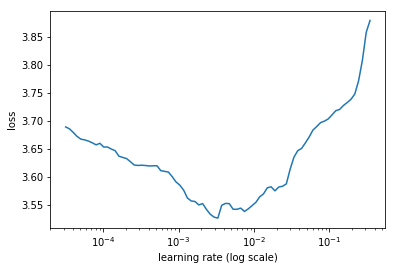

In [152]:
learn.sched.plot()

In [153]:
learn.fit(1e-3, 1, wds=1e-5, cycle_len=15, use_clr_beta=(5,20,0.95,0.75))

epoch      trn_loss   val_loss   accuracy   mapk            
    0      2.83909    2.84615    0.236536   0.337997  
    1      2.394552   2.996897   0.241288   0.333861        
    2      2.169553   2.257163   0.372228   0.480201        
    3      2.026654   2.646378   0.326294   0.426786        
    4      1.923334   2.369828   0.394931   0.496304        
    5      1.813566   2.33024    0.387012   0.500088        
    6      1.693758   1.766431   0.488912   0.598381        
    7      1.531578   1.76347    0.516367   0.610436        
    8      1.32731    1.691502   0.526399   0.618796        
    9      1.135064   1.707754   0.546463   0.632964        
    10     0.970916   1.44838    0.599789   0.685938         
    11     0.793847   1.453384   0.616684   0.695882         
    12     0.600782   1.443348   0.628828   0.709345         
    13     0.462215   1.422076   0.630412   0.710665         
    14     0.378127   1.409478   0.640444   0.716121         


[array([ 1.40948]), 0.64044350605957612, 0.71612108412530795]

In [154]:
learn.save('2d_resnet_10s_2')

In [40]:
learn.load('resnet_3_connected')

In [64]:
learn.fit(1e-3, 1, wds=1e-5, cycle_len=5, use_clr_beta=(5,20,0.95,0.75))

epoch      trn_loss   val_loss   accuracy   mapk            
    0      1.824353   3.410902   0.265048   0.346357  
    1      1.919786   2.769285   0.337381   0.433298        
    2      1.708295   1.931068   0.456177   0.563534        
    3      1.382881   1.513866   0.577614   0.669395        
    4      1.118543   1.409156   0.605597   0.69201         


[array([ 1.40916]), 0.60559662078224996, 0.69200985568461792]

In [65]:
learn.save('2d_resnet_trim_adj_2')

In [146]:
learn.load('resnet_2_connected')

In [66]:
learn.fit(1e-3, 1, wds=1e-5, cycle_len=5, use_clr_beta=(5,20,0.95,0.75))

epoch      trn_loss   val_loss   accuracy   mapk            
    0      1.333573   2.444052   0.399155   0.501408  
    1      1.677367   2.170311   0.407603   0.51144         
    2      1.409418   2.532168   0.378564   0.470961        
    3      1.118843   1.414954   0.610876   0.695882        
    4      0.835637   1.342595   0.628828   0.712073         


[array([ 1.34259]), 0.62882787706733634, 0.71207321365716314]

In [67]:
learn.save('2d_resnet_trim_adj_3')

In [72]:
learn.load('2d_resnet_trim_adj_3')

In [68]:
learn.freeze()

In [69]:
learn.fit(1e-3, 3, wds=1e-5)

epoch      trn_loss   val_loss   accuracy   mapk            
    0      1.475328   1.930132   0.492608   0.593013  
    1      1.391155   1.883881   0.501056   0.592397        
    2      1.327014   1.829744   0.515312   0.608765        


[array([ 1.82974]), 0.51531151003167897, 0.60876451953537492]

In [52]:
learn.load('resnet_2_connected')

In [60]:
learn.model.eval()
val_preds = learn.predict_with_targs()

val_acc = accuracy_np(*val_preds)
val_map = mapk_np(*val_preds)

print(f'Val Acc: {val_acc:.3f}, Val MAP: {val_map:.3f}')

Val Acc: 0.533, Val MAP: 0.625


### Predictions

In [155]:
multi_preds, y = learn.TTA(is_test=True)

In [156]:
preds = np.mean(multi_preds, 0)

In [157]:
np.save(PATH/'tmp/preds8.npy', preds)

In [158]:
classes = np.array(sorted(trn.label.unique())); classes[:5]

array(['Acoustic_guitar', 'Applause', 'Bark', 'Bass_drum', 'Burping_or_eructation'],
      dtype='<U21')

In [159]:
top_3_idx = [np.argsort(preds[i])[-3:][::-1] for i in range(len(test_fnames))]
pred_labels = [list(classes[[top_3_idx[i]]]) for i in range(len(test_fnames))]
preds = [" ".join(ls) for ls in pred_labels]
preds[:5]

['Trumpet Oboe Harmonica',
 'Hi-hat Shatter Gong',
 'Cello Double_bass Microwave_oven',
 'Trumpet Oboe Saxophone',
 'Electric_piano Bass_drum Double_bass']

In [160]:
tested = [md.test_ds.fnames[i].split('/')[-1] for i in range(len(test_fnames))]

In [161]:
idx = []
for fname in test_fnames:
    for name in tested:
        if name == fname:
            idx.append(tested.index(name))

In [162]:
[tested[i] for i in idx[:5]]

['00063640.wav',
 '0013a1db.wav',
 '002bb878.wav',
 '002d392d.wav',
 '00326aa9.wav']

In [163]:
test_fnames[:5]

['00063640.wav',
 '0013a1db.wav',
 '002bb878.wav',
 '002d392d.wav',
 '00326aa9.wav']

In [164]:
test['label'] = [preds[i] for i in idx]

In [165]:
test.head()

,fname,label
0,00063640.wav,Finger_snapping Scissors Microwave_oven
1,0013a1db.wav,Flute Saxophone Oboe
2,002bb878.wav,Bass_drum Knock Gunshot_or_gunfire
3,002d392d.wav,Acoustic_guitar Snare_drum Tambourine
4,00326aa9.wav,Oboe Flute Telephone


In [166]:
test.to_csv(PATH/'tmp/sub7.csv', index=False)

In [167]:
test.shape

(9400, 2)

In [168]:
submission = pd.read_csv(PATH/'tmp/sub7.csv'); submission.head()

,fname,label
0,00063640.wav,Finger_snapping Scissors Microwave_oven
1,0013a1db.wav,Flute Saxophone Oboe
2,002bb878.wav,Bass_drum Knock Gunshot_or_gunfire
3,002d392d.wav,Acoustic_guitar Snare_drum Tambourine
4,00326aa9.wav,Oboe Flute Telephone
